# Proyecto
* Karen Fuentes
* Marco Ramirez
* Jenifer Arce

# Sección 1. Entendimiento del negocio y enfoque analítico


## Generalidades

|||
|-|-|
| **Oportunidad/problema Negocio**  |Cómo detectar noticias falsas en la política con el fin de evitar la polarización y manipulación de la opinión pública.|
| **Objetivos** |Desarrollar un modelo de aprendizaje automático capaz de identificar noticias falsas en política con alta exactitud y precisión.|
| **Criterios de éxito** |  Un alto desempeño en métricas de precisión, recall y F1-score, así como minimizar errores de tipo I y II.|
|**Organización y rol beneficiados**|El gobierno nacional,la comunidad internacional, ciudadanos y organismos electorales se verán beneficiados al tener acceso a información confiable para la toma de decisiones. |

## Impacto y enfoque analítico

La implementación de un modelo de detección de noticias falsas en Colombia y en latinoamétrica tendría un impacto sobre la polarización política y manipulación de la opinión pública, así como aumentar la confianza en las instituciones del país y en general mejorar la calidad de la información disponible para los ciudadanos.

De acuerdo con datos de Statista (2024) el 49% de personas en Latinoamérica leen por lo menos una noticia falsa al día. Por lo tanto, la realización del modelo serviría para distintos tipos de usuarios, que pueden ser ciudadanos que quieran verificar la veracidad de las noticias, o empresas que necesiten analizar muchas noticias día al día.

La categoría del análisis a realizar es **predictiva** ya que buscamos predecir si una noticia es falsa o verdadera con base a su título y descripción. El tipo de aprendizaje es **supervisado** ya que el modelo aprende de un conjunto de datos de noticias que ya estan etiquetadas como falsas o verdaderas. La tarea de aprendizaje es de **clasificación binaria** basada en si es una noticia verdadera (1) o falsa (0). Las técnicas y algoritmos a utilizar son **preprocesamiento de datos (tokenización, lematización y vectorización)** al igual que algoritmos como **Naive Bayes, Random Forest, entre otros**.

# Clonar repo para los archivos

In [5]:
# !git clone https://github.com/jennn-arce/proy1BI.git

## Usar esta línea cada vez que necesiten hacer pull

In [6]:
# %cd /content/proy1BI
# %ls
# !git pull

# 0. Carga de datos y librerías

In [8]:
# Importaciones generales
import sys
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import contractions
import inflect
import matplotlib.pyplot as plt

# Procesamiento de lenguaje natural (NLP)
import nltk
from nltk import word_tokenize, sent_tokenize, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Descarga de recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Configuración de stopwords y tokenizador
stop_words = stopwords.words('spanish')
wpt = nltk.WordPunctTokenizer()
ps = PorterStemmer()

# Modelado y machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
# XGBoost
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcoramirez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcoramirez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def getTrainData():
    try:
        df = pd.read_csv('Files/fake_news_spanish.csv',
                        encoding='utf-8', sep=";")
    except:
        df = pd.read_csv('Files/fake_news_spanish.csv',
                        encoding='utf-8', sep=";")

    return df

def getTestData():
    try:
        data_test = pd.read_csv(
            'Files/fake_news_test.csv', encoding='utf-8', sep=";")
    except:
        data_test = pd.read_csv('Files/fake_news_test.csv', encoding='utf-8',
                                sep=";")
    return data_test

df = getTrainData()
data_test = getTestData()

In [11]:
# df = pd.read_csv('fake_news_spanish.csv', encoding='utf-8', sep = ";")
# data_test = pd.read_csv('fake_news_test.csv', encoding='utf-8', sep = ";")

In [12]:
df.head(1)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023


In [13]:
print('data spanish', df.shape)
print('data test', df.shape)

data spanish (57063, 5)
data test (57063, 5)


#Sección 2. Entendimiento y preparación de los datos

# 2.1 Entendimiento de datos

In [14]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

Identificamos que las columnas de tipo object no tienen el formato correcto, estas se cambiaran más adelante.

In [15]:
df.head(10)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,26/05/2019
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,25/02/2021
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021


In [16]:
data_test.head(5)

,ID,Titulo,Descripcion,Fecha
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021


In [17]:
# descomentarlo cuando se vaya a entregar
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport

# perfil = ProfileReport(df, title="Perfilamiento de Datos", explorative=True)
# perfil.to_notebook_iframe()

* Número de variables: 5
* observaciones: 57063
* celdas faltantes 35339
* no hay duplicados
* lablel -> 33158 en 1 , 23905 en 0
* 16 titulos faltantes, 90.5% únicos
* 0 descripciones faltantes, 87% únicos
* faltan 61.9%fechas



###Variables categóricas

In [18]:
df.describe()

,Label
count,57063.000000
mean,0.581077
std,0.493387
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


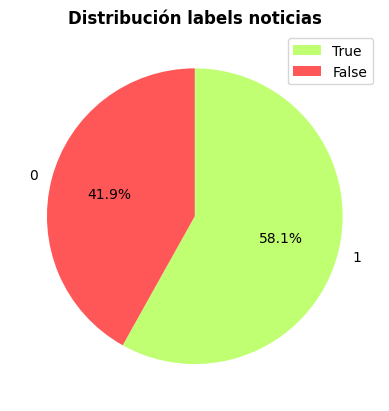

In [19]:
import matplotlib.pyplot as plt


# Plotting the value counts
label_counts = df["Label"].value_counts()
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90,
                  counterclock=False, colors=['#c1ff72', '#ff5757'])
plt.legend(['True', 'False'])
plt.title('Distribución labels noticias', fontweight='bold')
plt.ylabel('')
plt.show()

Se puede evidenciar que de la variable **label** el valor mínimo es 0 y el máximo es 1. La media es de 0.581, es decir que el 58.1% de las noticias son verdaderas. Esto también se evidencia con la mediana ya que su valor es de 1.

Adicionalmente la variable **ID** por el momento es categorica ya que todos los valores son 'ID'. Haremos un manejo de esta variable más adelante

### Variables de texto

Las dos variables de texto identificadas son **titulo** y **descripción**. Se observa que las palabras más frecuentes son stopwords como "de", "los", "que", "la", "del", "y", "a", "por", "para". Estas serán eliminadas en la fase de preprocesamiento con **lematización**. Así mismo evicenciamos palabras con tíldes, mucha puntuación y palabras con caracteres no ASCII que puede generar ruido en los datos por lo cual se le dara un manejo en el preprocesamiento.

##Variable DateTime

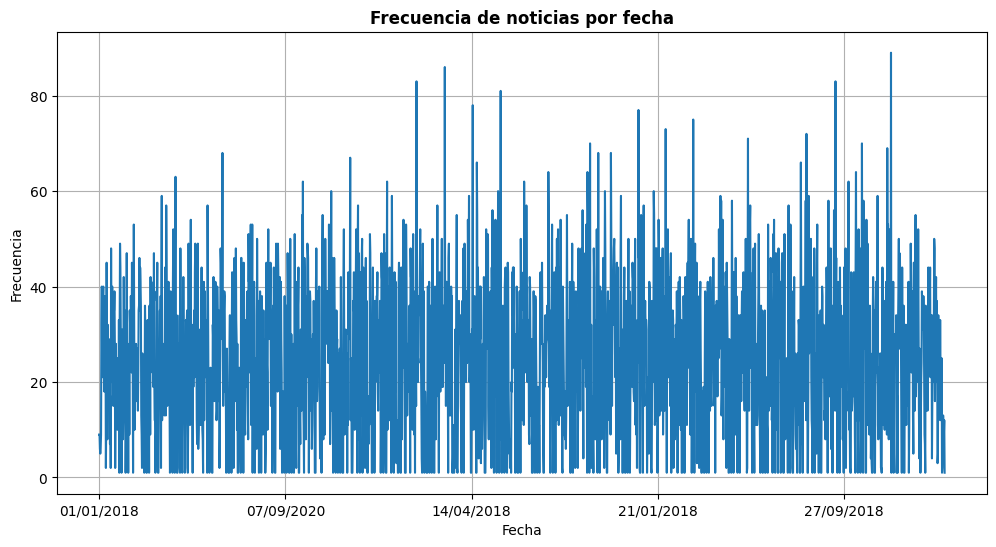

In [20]:
# Plotting the frequency of each date
conteo_fechas = df['Fecha'].value_counts().sort_index()
conteo_fechas.plot(kind='line', figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.title('Frecuencia de noticias por fecha', fontweight='bold')
plt.show()

Se evidencia que las noticias a analizar son de los últimos nueve años. Con la noticia más antigua detectada siendo del 01/02/2016 y la más reciente del 28/12/2024.

# 2.2 Preparación de datos

### Completitud

In [21]:
# Cálculo de porcentaje de valores nulos por columna
((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)

Titulo         0.00028
ID             0.00000
Label          0.00000
Descripcion    0.00000
Fecha          0.00000
dtype: float64

### Unicidad

In [22]:
df.duplicated().sum()

np.int64(445)

In [23]:
# Duplicados parciales
numeric_cols=['Titulo','Descripcion']
for col in numeric_cols:
    num_duplicated = df.duplicated(subset = col).sum()
    print(f"{col}: {num_duplicated}")

Titulo: 5458
Descripcion: 7425


Si una descripción se repite 2 veces puede ser para poner titulos diferentes, o fechas diferentes, y de esta manera son 2 datos únicos y que se deben tener en cuenta y no borrarlos. Pero si el titulo, la descripcion y el label se repiten, ahí si son datos no relevantes, dado que dan la misma información

## Consistencia

0 sígnfica que la noticia es falsa y 1 que es verídica

In [24]:
# Voy a revisar la columna label
print(df["Label"].value_counts())
print('='*10, 'Distribución labels', '='*10)
print('label 1:',round(df[df['Label'] == 1].shape[0]/df.shape[0],4),'%')
print('label 0:',round(df[df['Label'] == 0].shape[0]/df.shape[0],4),'%')


Label
1    33158
0    23905
Name: count, dtype: int64
========== Distribución labels ==========
label 1: 0.5811 %
label 0: 0.4189 %


##**validez**

In [25]:
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
conteo_fechas = df['Fecha'].value_counts().sort_index()
conteo_fechas

Fecha
2016-02-01    1
2016-03-03    1
2016-03-12    1
2016-04-02    1
2016-04-03    1
             ..
2024-11-02    1
2024-11-03    1
2024-11-06    1
2024-11-08    1
2024-12-11    1
Name: count, Length: 906, dtype: int64

Las fechas tienen sentido, acotando el rango de fechas de inicios de 2016 a 2024, validando que no hay datos extraños (años mucho anteriores al rango) o ninguna fecha es en el futuro, entonces todos son validos en esta medida

**Conclusión calidad de datos:**

UNICIDAD:
No hay valores únicos para el ID para cada noticia. Por lo cual, se generó un ID para cada noticia de esta columna. De esta manera ahora hay un 100% de valores distintos para esta columna.
Hay 90.4% títulos distintos y 87% descripciones distintas. Solo hay 16 registros duplicados.

CONSISTENCIA:
Al revisar la consistencia en la columna Labels todo está en 0 y 1. Por lo cual, no hay problemas al momento de hacer el modelo.


COMPLETITUD:
Con respecto a la completitud, la columna que tiene más problemas es la de fecha. Hay 61.2% de  valores faltantes para esta columan. Debido a que el problema es de procesamiento de texto, solo en el x train tuvimos en cuenta el título y descripción.

VALIDEZ:
No hay columnas para revisar la validez.

## Selección de hiperparametros

En el notebook marco aproach están las pruebas realizadas para la selección de hiperparametros. En general el proceso fue un poco largo, en el otro notebook pueden ver los resultados más detalllados (el notebook quedaría muy pesado si dejabamos las pruebas acá).

Los resultados general de esta etapa son:

Para la preparación de datos, primero realizamos una limpieza eliminando tildes, ñ’s, puntuaciones y stopwords, además de convertir todo a minúsculas. Luego aplicamos tokenización, dividiendo el texto en palabras y manejando contracciones. Decidimos no aplicar stemming tras pruebas que mostraron mejores resultados sin él, pero sí utilizamos lematización para normalizar las palabras. Después, volvimos a unir las palabras procesadas y seleccionamos los campos relevantes. Finalmente, aplicamos vectorización con TF-IDF, combinando título y descripción en un solo vector para alimentar el modelo de clasificación.

In [26]:
from num2words import num2words
from nltk.stem.snowball import SnowballStemmer


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode(
              'ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words


def normalize_text(text, repetar_español = False):
    if not repetar_español:
        text = text.replace('á', 'a')
        text = text.replace('é', 'e')
        text = text.replace('í', 'i')
        text = text.replace('ó', 'o')
        text = text.replace('ú', 'u')
        text = text.replace('ü', 'u')
        text = text.replace('ñ', 'n')

    # Eliminate punctuation and special characters by replacing them
    text = text.replace('(', '').replace(')', '')
    text = text.replace('[', '').replace(']', '')
    text = text.replace('{', '').replace('}', '')
    text = text.replace('<', '').replace('>', '')
    return text.lower()

def to_lowercase(words, respetar_español = False):
    return [normalize_text(word, respetar_español) for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = num2words(word, lang='es')
           new_words.append(new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    nuevas_palabras = []
    for palabra in words:
        if palabra is not None:
            if palabra not in stopwords.words('spanish'):
                nuevas_palabras.append(palabra)
    return nuevas_palabras

def corregir_contracciones_espanol(texto):
    texto = texto.replace('al ', 'a el ').replace(
        'al.', 'a el.')  # "al" a "a el"
    # "del" a "de el"    # Agrega más reglas aquí según sea necesario
    texto = texto.replace('del ', 'de el ').replace('del.', 'de el.')
    return texto

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Simple lemmatization for verbs in list of tokenized words"""
    # Simple rule-based lemmatization (you can extend this as needed)
    lemmatized_words = []
    for word in words:
        if word.endswith('ar'):
            lemmatized_words.append(word[:-2])  # Remove 'ar' (basic rule)
        elif word.endswith('er'):
            lemmatized_words.append(word[:-2])  # Remove 'er' (basic rule)
        elif word.endswith('ir'):
            lemmatized_words.append(word[:-2])  # Remove 'ir' (basic rule)
        else:
            # Return the word as is if no rule applies
            lemmatized_words.append(word)
    return lemmatized_words

def stem_and_lemmatize(words, stems_parameter = True, lemmas_parameter = True):
    """Stem and Lemmatize words"""
    if stems_parameter and lemmas_parameter:
        stems = stem_words(words)
        lemmas = lemmatize_verbs(words)
        return stems + lemmas
    elif lemmas_parameter:
        lemmas = lemmatize_verbs(words)
        return lemmas
    elif stems_parameter:
        stems = stem_words(words)
        return stems
    else:
        return words

def preprocessing(words, respetar_español = False, respetar_ascii = False):
    words = words.split()
    words = to_lowercase(words, respetar_español)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    if not respetar_ascii:
        words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

Estas funciones son las que nos van a ayudar a pulir los datos previo a la vectorización

In [27]:
def transfor_data(df):
    columnas = ['Titulo', 'Descripcion']
    df = df[columnas]
    # fill na with ''
    df = df.fillna('')
    for columna in columnas:
        df[columna] = df[columna].apply(corregir_contracciones_espanol)
        df[columna] = df[columna].apply(lambda x: preprocessing(x, False, True))
        df[columna] = df[columna].apply(lambda x: stem_and_lemmatize(x, False, True))
        df[columna] = df[columna].apply(lambda x: ' '.join(map(str, x)))
    return df

def get_good_test_data(respetar_espanol=False, respetar_ascii=True, lemmatize=True, stem=False, columns=['Titulo', 'Descripcion'], downsampling_percentage = 0):
    trainData = getTrainData()
    trainData = trainData[trainData["Titulo"].notna()]
    trainData = trainData.drop_duplicates(
        subset=["Titulo", 'Descripcion', 'Label'], keep='first')
    for columna in columns:
        trainData[columna] = trainData[columna].apply(
            corregir_contracciones_espanol)
        trainData[columna] = trainData[columna].apply(
            lambda x: preprocessing(x, respetar_espanol, respetar_ascii))
        if lemmatize:
            trainData[columna] = trainData[columna].apply(
                lambda x: stem_and_lemmatize(x, stem, lemmatize))
        trainData[columna] = trainData[columna].apply(
            lambda x: ' '.join(map(str, x)))

    count_label_0 = trainData[trainData['Label'] == 0].shape[0]
    count_label_1 = trainData[trainData['Label'] == 1].shape[0]
    difference_1_0 = count_label_1 - count_label_0

    if downsampling_percentage > 0:
        df_label_1 = trainData[trainData['Label'] == 1].sample(
            n=count_label_0 + int(difference_1_0 * downsampling_percentage), random_state=42)
        df_label_0 = trainData[trainData['Label'] == 0]
        trainData = pd.concat([df_label_0, df_label_1])

    return trainData[columns+['Label']]

Dado unas iteraciones que realizamos en local, estas son los 'hiperparametros' que tuvimos en cuenta para la preparación de datos. Los mejores resultados los obtuvimos quitando caracteres del español como la ñ, las tildes, etc, no removiendo caracteres fuera del ASCII, Lemmatizando quitar los ar, er, ir, en verbos, y no hacer stemming.

In [28]:
trainData = get_good_test_data()

In [29]:
trainData

,Titulo,Descripcion,Label
0,the guardian va sanchez europa necesita apuest...,diario britanico publico pasado jueves editori...,1
1,revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...,0
2,ahora nunca joan fust estatuto valenciano cump...,valencianismo convoca castello fiesta grande c...,1
3,iglesias alienta yolanda diaz erc eh bildu neg...,politica igua negoci empresarios negoci grupos...,1
4,puigdemont seria ninguna tragedia repeticion e...,entrevista punt avui lid jxcat desdramatizado ...,0
...,...,...,...
57058,defensor pueblo reclama comunidad madrid datos...,gobierno regiona indicado atencion dia incluye...,1
57059,equo plantea ced presidencia comunidad madrid ...,si higiene democratica lleva exigencia ten pas...,0
57060,alberto garzon borbones ladrones hecho histori...,coordinador federa iu asegura monarquia putref...,1
57061,vox exige entr gobierno castilla leon cara vic...,santiago abascal vox derecho deb form gobierno...,1


¡De esta forma se terminan viendo los datos con los que vamos a entrenar el modelo!

## Función para evaluar los modelos

Para evaluar el rendimiento de los modelos, seleccionamos tres métricas clave: F1-Score, Recall y ROC Curve. F1-Score combina precisión y recall en una sola medida, asegurando un balance entre ambas, con el objetivo de alcanzar un valor cercano a 1. Recall mide cuántas noticias falsas detectamos correctamente, priorizándolo sobre la precisión, ya que es más riesgoso dejar pasar una noticia falsa que clasificar erróneamente una verdadera. Finalmente, la ROC Curve nos ayuda a visualizar qué tan bien el modelo separa noticias falsas y verdaderas, donde un área bajo la curva (AUC) más alta indica un mejor rendimiento en la clasificación.

In [30]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def evaluate_model(y_test, y_pred, labels, model_name):
    """
    Evalúa el rendimiento de un modelo de clasificación.

    Parámetros:
    - y_test: Valores reales de la clasificación.
    - y_pred: Predicciones del modelo.
    - model_name: Nombre del modelo para impresión (opcional).
    """
    print(f"\nEvaluación del modelo: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test,y_pred) ) # ESTA SERA LA METRICA PRINCIPAL
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Calcular F1 Score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"F1 Weighted Score: {f1_weighted}")
    print(f"F1 Macro Score: {f1_macro}")

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                                  display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    #RocCurveDisplay.from_estimator(model, x_test_MNB, y_test_MNB)

# Training

Para el proceso de entrenamiento del modelo, se utilizaron las columnas de título y descripción después de aplicar la tokenización. Durante las pruebas, investigamos que al sumar directamente los textos de ambas columnas antes de tokenizar, el desempeño de los modelos se veía afectado negativamente. Además al consultar con profesores confirmamos esto. Esto sugiere que la tokenización aplicada sobre los textos combinados no preservaba adecuadamente la estructura de la información, lo que generaba una perdida en la representación de los datos.

Para mitigar este efecto, en lugar de sumar los textos antes de la tokenización, optamos por tokenizar cada columna por separado y luego aplicar la vectorización a cada una. Finalmente, concatenamos las representaciones vectorizadas de ambas columnas, lo que permitió mejorar la calidad de los datos de entrada y optimizar el rendimiento del modelo.

In [31]:
from sklearn.compose import ColumnTransformer

text_transformer_basic = ColumnTransformer(
    transformers=[
        ("Titulo_tfidf", TfidfVectorizer(), "Titulo"),
        ("desc_tfidf", TfidfVectorizer(), "Descripcion")
    ]
)

In [32]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2,
             linestyle='--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    labels = sorted(set(y_test))  # Ensure labels are sorted and unique
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


def evaluate_pipeline(pipeline, X_test, y_test, title:str):
    y_pred = pipeline.predict(X_test)
    results = classification_report(y_test, y_pred, output_dict=True)
    df_results = pd.DataFrame(results).T

    print(f"\n==================== EVALUACIÓN DEL {title.upper()} ====================")
    print("Métricas clave del desempeño del modelo:")
    print("--------------------------------------------------------------")
    print(df_results[['precision', 'recall', 'f1-score']].round(4))
    print("--------------------------------------------------------------")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print("==============================================================\n")

In [33]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

def all_models(dataframe, text_transformer, parameters={} ,cross_validation=True):
    X = dataframe[['Titulo', 'Descripcion']]
    y = dataframe['Label']

    # Apply TfidfVectorizer separately to 'Titulo' and 'Descripcion'
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    if 'min_samples_split' in parameters:
        model = RandomForestClassifier(n_estimators=parameters['n_estimators'], max_depth=parameters['max_depth'], min_samples_split=parameters['min_samples_split'])
    elif len(parameters) <1:
        model = MultinomialNB()
    else:
        model = XGBClassifier(eval_metric='logloss', n_estimators=parameters['n_estimators'], max_depth=parameters['max_depth'], learning_rate=parameters['learning_rate'])

    pipeline = Pipeline([
        ("vectorizer", text_transformer),
        ("classifier", model)
    ])

    pipeline.fit(X_train, y_train)

    if cross_validation:
        cv_scores = cross_val_score(
            pipeline, X, y, cv=5, scoring='f1_macro', n_jobs=-1)
        print(f"F1-score promedio en validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        results = classification_report(y_test, pipeline.predict(X_test), output_dict=True)
    else:
        y_pred = pipeline.predict(X_test)

        results = classification_report(y_test, y_pred, output_dict=True)
        print(f"\nModelo: XGBoost")
        print("Clasificación detallada:")
        print(pd.DataFrame(results).T)
    return results, pipeline

# 3 Modelado y evaluación

# Algoritmo Karen

Se utilizó XGBoost porque es un modelo potente y optimizado para tareas de clasificación, especialmente cuando se trabaja con grandes volúmenes de datos. Este algoritmo es una versión mejorada de los árboles de decisión, diseñada para ser más eficiente y precisa gracias a su implementación basada en gradiente boosting.

Es rápido y eficiente, tiene mecanismo de reducción de sobreajuste y funciona bien con representaciones de texto basadas en TF-IDF

In [34]:
karen_modelo = all_models(trainData, text_transformer_basic, {
                          'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2})

F1-score promedio en validación cruzada: 0.9184 (+/- 0.0025)


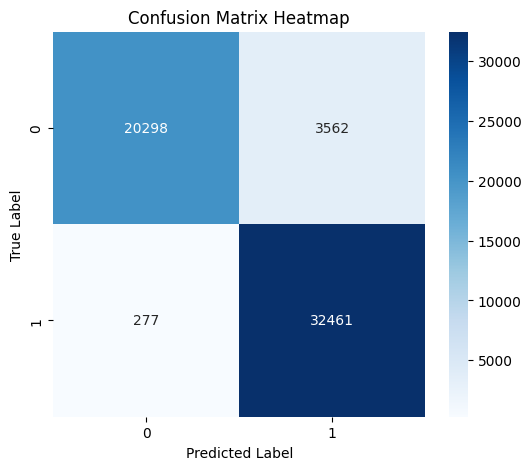

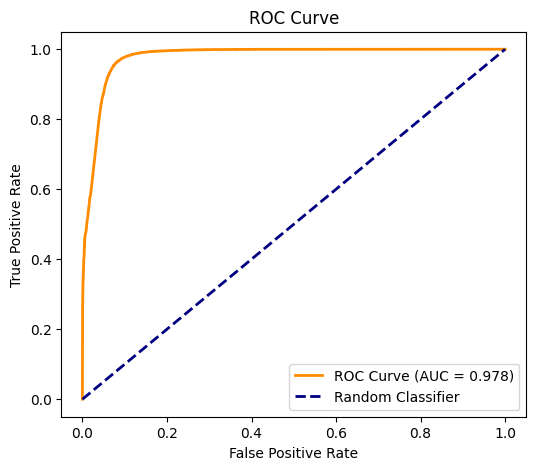


==================== EVALUACIÓN DEL MODELO DE KAREN ====================
Métricas clave del desempeño del modelo:
--------------------------------------------------------------
              precision  recall  f1-score
0                0.9865  0.8507    0.9136
1                0.9011  0.9915    0.9442
accuracy         0.9322  0.9322    0.9322
macro avg        0.9438  0.9211    0.9289
weighted avg     0.9371  0.9322    0.9313
--------------------------------------------------------------
Accuracy: 0.9322



In [35]:
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred = karen_modelo[1].predict(X_test)
plot_confusion_matrix(trainData['Label'], y_pred)
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred_proba = karen_modelo[1].predict_proba(X_test)[:, 1]
plot_roc_curve(trainData['Label'], y_pred_proba)
evaluate_pipeline(karen_modelo[1], X_test, trainData['Label'], title = 'Modelo de Karen')

El modelo XGBoost presenta un buen rendimiento en la detección de noticias falsas, con una accuracy del 93.22% y un F1-Score de 0.9313, lo que indica un balance adecuado entre precisión y recall. Su recall para la clase 0 (noticias falsas) es de 0.8507, lo que demuestra una alta capacidad para identificar contenido falso, aunque aún deja pasar algunos falsos negativos. La curva ROC muestra un AUC de 0.992, lo que indica una excelente capacidad de discriminación entre noticias verdaderas y falsas

# Algoritmo Marco
Se utilizó Random Forest porque es un modelo robusto y efectivo para tareas de clasificación. Este algoritmo es un conjunto de múltiples árboles de decisión que combinan sus predicciones para mejorar la precisión y reducir el riesgo de sobreajuste.

Dado el contexto de noticias falsas trabaja bien porque maneja bien datos ruidosos, es eficiente y fácil de interpretar

In [36]:
marco_modelo = all_models(trainData, text_transformer_basic, {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300})

F1-score promedio en validación cruzada: 0.9072 (+/- 0.0027)


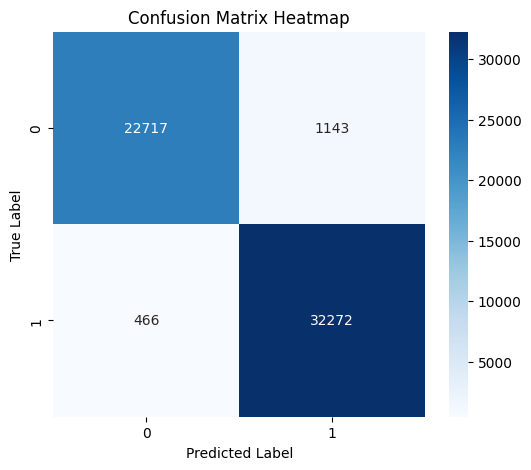

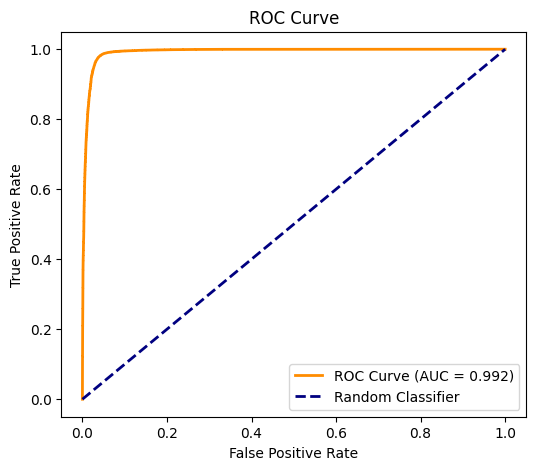


==================== EVALUACIÓN DEL MODELO DE MARCO ====================
Métricas clave del desempeño del modelo:
--------------------------------------------------------------
              precision  recall  f1-score
0                0.9799  0.9521    0.9658
1                0.9658  0.9858    0.9757
accuracy         0.9716  0.9716    0.9716
macro avg        0.9728  0.9689    0.9707
weighted avg     0.9717  0.9716    0.9715
--------------------------------------------------------------
Accuracy: 0.9716



In [37]:
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred = marco_modelo[1].predict(X_test)
plot_confusion_matrix(trainData['Label'], y_pred)
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred_proba = marco_modelo[1].predict_proba(X_test)[:, 1]
plot_roc_curve(trainData['Label'], y_pred_proba)
evaluate_pipeline(marco_modelo[1], X_test,
                  trainData['Label'], title='Modelo de Marco')

El modelo Random Forest muestra un alto desempeño en la detección de noticias falsas, con una accuracy de 97.24% y un F1-Score de 0.9724, lo que indica una clasificación precisa y balanceada. Destaca su recall para la clase 0 (noticias falsas) de 0.9534, lo que significa que logra detectar la mayoría de las noticias falsas con pocos falsos negativos. Además, el AUC de 0.992 demuestra una excelente capacidad de diferenciación entre noticias reales y falsas, consolidando a Random Forest como un modelo confiable y robusto.

# Algoritmo Jenifer Arce

Seleccioné algoritmo Naive Bayes debido a que es muy utilizada en tareas de clasificación de texto y su capacidad para manejar grandes volúmenes de datos de manera eficiente. En el contexto de nuestro proyecto de detección de noticias falsas en política, este clasificador resulta útil porque permite asignar probabilidades a cada noticia en función de su contenido, determinando si es verdadera o falsa (IBM, s.f.). El modelo se basa en el Teorema de Bayes, el cual calcula la probabilidad de que una noticia pertenezca a una categoría dada la presencia de ciertas palabras en su texto. Su capacidad para detectar patrones lingüísticos comunes en noticias falsas nos permitirá analizar cómo ciertas palabra o fraspueden indicar una mayor probabilidad de desinformación.

Para entrenar el modelo, se utilizaron los títulos y descripciones de las noticias después de un proceso de preprocesamiento y vectorización, que se hizo previamente. Además de probar el texto con el vector TDIF, lo probé con vector de conteo:

* TF-IDF (Term Frequency-Inverse Document Frequency): Asigna más peso a las palabras importantes y reduce la influencia de las más comunes.
* Count Vectorization: Solo cuenta cuántas veces aparece cada palabra en el texto


## Detalles relevantes del algoritmo:
* Debido a su eficiencia computacional (IBM, s.f.)., Naive Bayes es una alternativa viable cuando se trabaja con grandes volúmenes de noticias en tiempo real. Lo que en el contexto del proyecto y el entendimiento del negocio, facilita la implementación de un sistema de detección rápido y con resultados interpretables para noticias.
* Si se usa count vectorizer el modelo se basa en la frecuencia de las palabras. Si se usa TF-IDF, el modelo considera la relevancia de cada término.
* En las fuentes pueden encontrar las formulas del modelo. En general el funcionamiento se basa en aplicar el teorema de Bayes, donde la probabilidad posterior se obtiene multiplicando la probabilidad previa de la categoría P(y) (que es el label) por la probabilidad condicional de observar las palabras en esa categoria o clase P(X∣y). Luego, cada palabra que esté en el vectores, contribuye a la clasificación mediante P(x_i∣y), que se estima con suavizado de Laplace para evitar valores de probabilidad cero. Finalmente, el modelo predice el label y (1 o 0) maximizando la probabilidad P(y∣X), eligiendo la que tenga mayor valor entre las posibles opciones.

## Fórmulas:

Fuentes:

IBM. (s.f.). Naive Bayes. IBM. https://www.ibm.com/es-es/think/topics/naive-bayes


UpGrad. (2024, 19 noviembre). Multinomial naive Bayes explained: Function, advantages & disadvantages, applications. upGrad Blog. https://www.upgrad.com/blog/multinomial-naive-bayes-explained/

In [38]:
jen_modelo = all_models(trainData, text_transformer_basic)

F1-score promedio en validación cruzada: 0.8026 (+/- 0.0033)


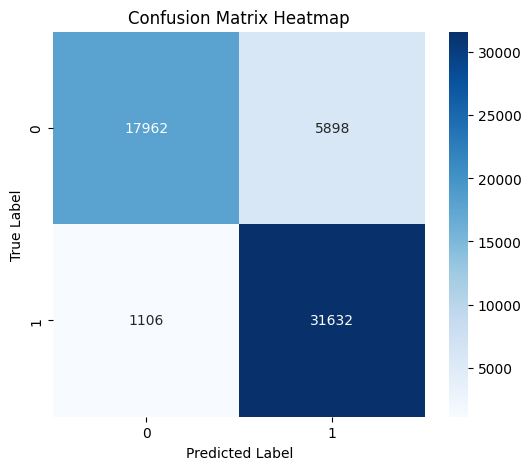

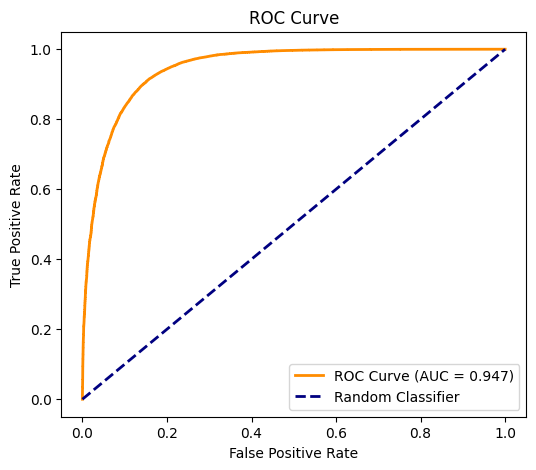


==================== EVALUACIÓN DEL MODELO DE JENIFER ====================
Métricas clave del desempeño del modelo:
--------------------------------------------------------------
              precision  recall  f1-score
0                0.9420  0.7528    0.8368
1                0.8428  0.9662    0.9003
accuracy         0.8763  0.8763    0.8763
macro avg        0.8924  0.8595    0.8686
weighted avg     0.8846  0.8763    0.8736
--------------------------------------------------------------
Accuracy: 0.8763



In [39]:
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred = jen_modelo[1].predict(X_test)
plot_confusion_matrix(trainData['Label'], y_pred)
X_test = trainData[['Titulo', 'Descripcion']]  # Ensure it's a DataFrame
y_pred_proba = jen_modelo[1].predict_proba(X_test)[:, 1]
plot_roc_curve(trainData['Label'], y_pred_proba)
evaluate_pipeline(jen_modelo[1], X_test,
                  trainData['Label'], title='Modelo de Jenifer')

El modelo basado en TF-IDF muestra un excelente desempeño, especialmente en la predicción del label 1, que es el más importante para mí. El recall para este label es de 0.96, lo que indica que el modelo captura casi todos los casos positivos, minimizando los falsos negativos. Además, el F1-score para el label 1 es de 0.90, lo que refleja un buen equilibrio entre precisión y recall. Esto significa que el modelo predice correctamente la mayoría de los casos positivos (noticias verdaderas). En general, estos resultados validan la efectividad del modelo con TF-IDF para el modelo, asegurando una identificación de noticias verdaderas, y también falsas.

# Intento con vector count

En Notebook del repositorio llamado intentoJeniferCountVectorizer.ipynb está el notebook con el intento del count vectorizer. En este intento de modelo intenté otros hiperparametros al momento de la realización del modelo, al igual que otra vectorización.

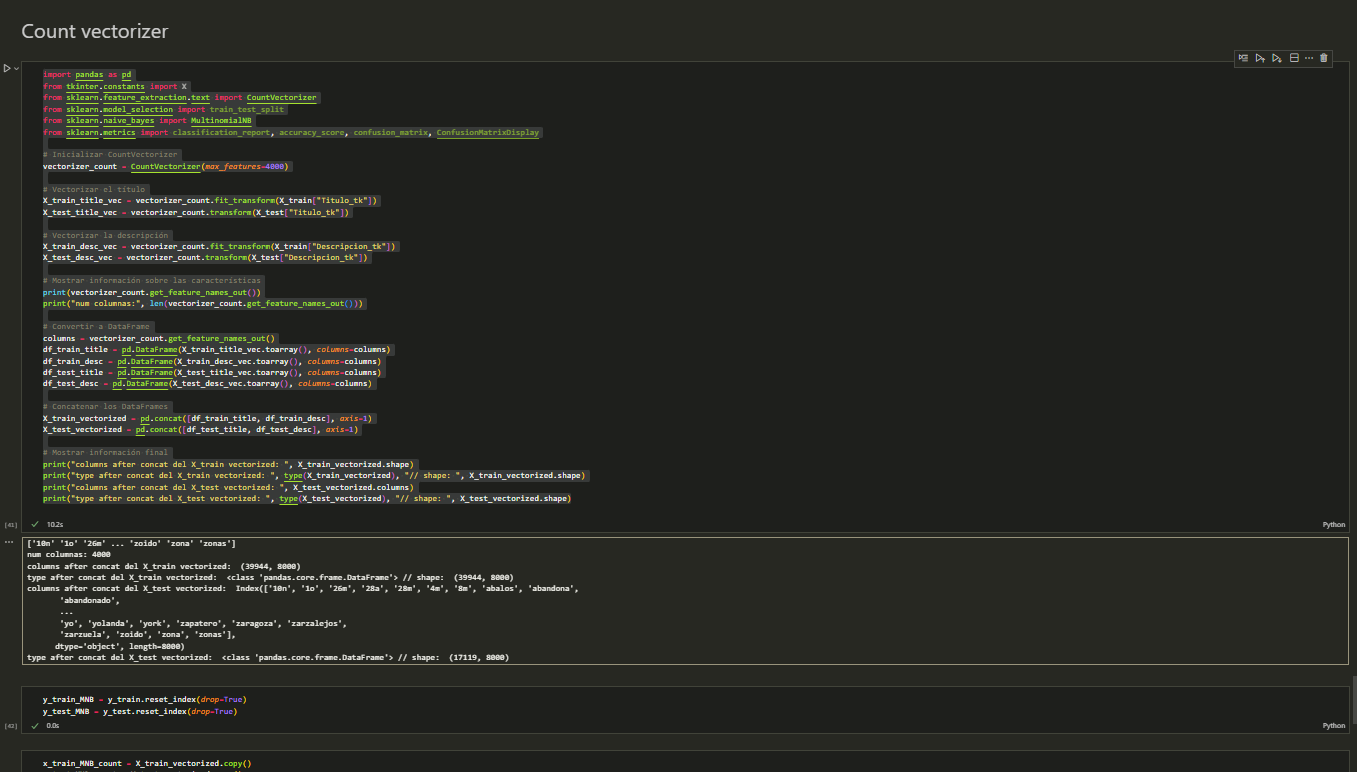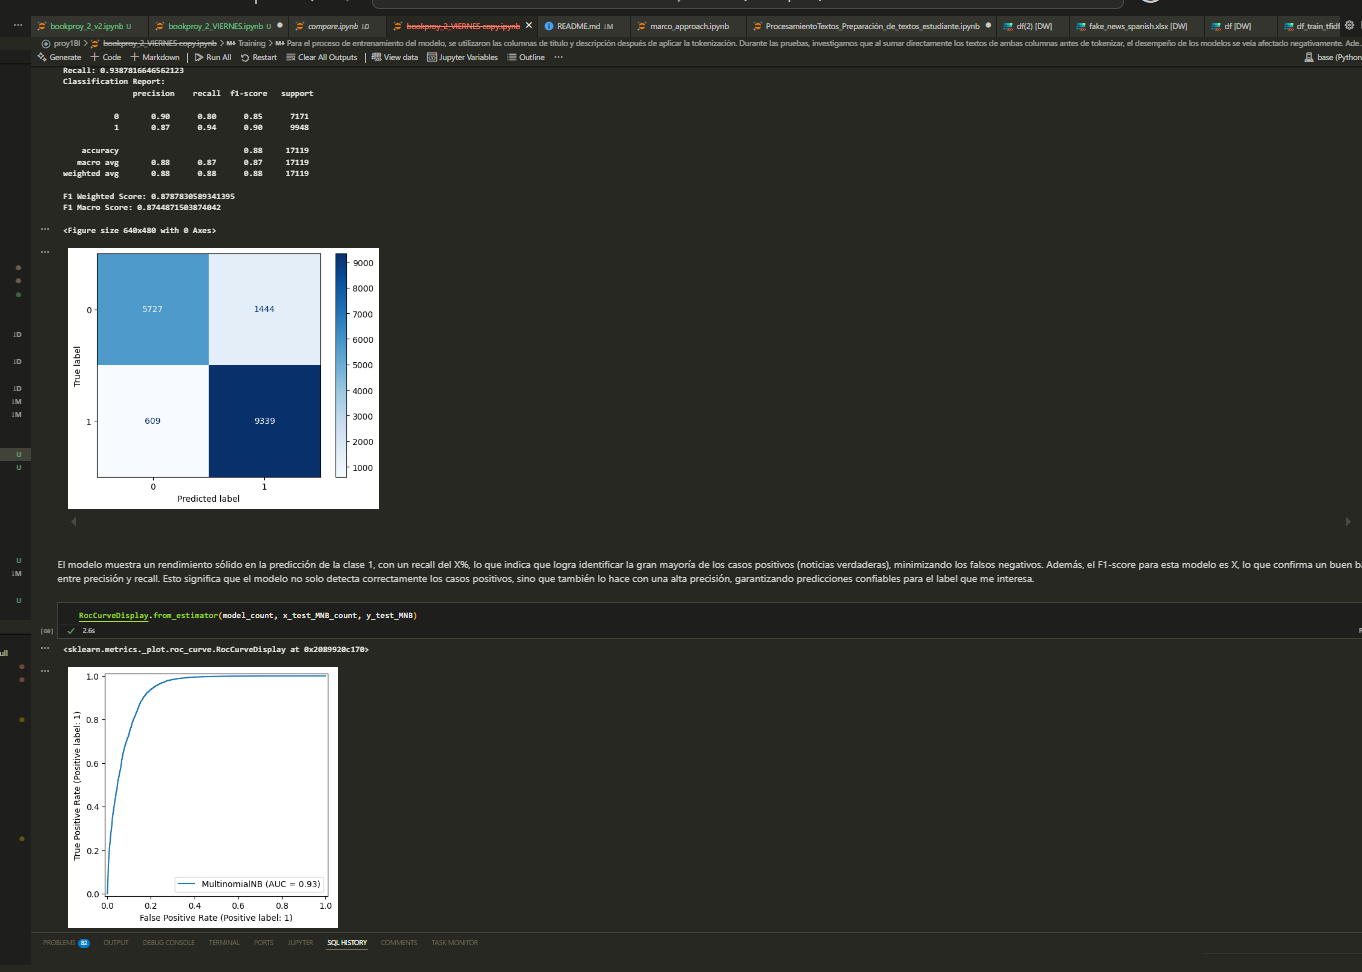

Los resultados generales fueron:

La curva ROC muestra que el modelo tiene un excelente desempeño. La línea se acerca al vértice superior izquierdo, lo que indica una alta tasa de verdaderos positivos y una baja tasa de falsos positivos. El área bajo la curva (AUC = 0.93) confirma que el modelo distingue muy bien entre los labels, especialmente el label 1, que es el que me interesa predecir con precisión. Un AUC de 0.93 significa que, en el 93% de los casos, el modelo asigna una mayor probabilidad al label correcto en comparación con un incorrecto, lo que refuerza su efectividad.


Con el CountVectorizer es una manera efectiva de abordar el problema, y los resultados muestran un recall del 94% para el label 1, lo que significa que detecta correctamente la mayoría de las noticias que son verdaderas. Además, el F1-score de X indica un buen equilibrio entre precisión y recall. Comparado con el modelo basado en TF-IDF, la diferencia en rendimiento no es significativa, lo que sugiere que ambos enfoques son válidos para las necesidades de negocio que identificamos.



# 5 Resultados

### *Comparación de Modelos y Selección del Mejor*  

Para elegir el mejor modelo, analizamos los resultados obtenidos por *XGBoost, Random Forest y Naive Bayes (MultinomialNB), comparando sus métricas clave y su alineación con el objetivo del proyecto. Nuestro enfoque está en maximizar el recall para la clase 0 (noticias falsas)*, asegurando que la menor cantidad posible de noticias falsas sean clasificadas erróneamente como verdaderas.  

#### *Comparación de Modelos*  
Cada modelo mostró fortalezas y diferencias en su rendimiento:  

- *XGBoost* logró un recall de 0.8507 en la clase 0, con un F1-score de 0.9313 y un AUC de 0.992, lo que indica una alta capacidad de discriminación.  
- *Random Forest* obtuvo el mejor recall en la clase 0 (0.9534), junto con un F1-score de 0.972 y un AUC de 0.992, consolidándose como la mejor opción para minimizar falsos negativos.  
- Naive Bayes (MNB) mostró un desempeño en *recall para la clase 0 (0.7528), lo que indica que deja pasar una cantidad considerable de noticias falsas como verdaderas, pero las noticias verdaderas tiene un recall de 0.96 y un AUC de 0.947*.

#### *Selección del Mejor Modelo*  
Basándonos en estas métricas, *Random Forest es la mejor opción* para nuestro caso de uso, ya que ofrece el *mayor recall en la detección de noticias falsas*, reduciendo el impacto de la desinformación. Aunque XGBoost también presenta un buen desempeño, su recall más bajo lo hace menos confiable para nuestra prioridad. Naive Bayes, aunque eficiente y rápido, no cumple con el criterio de recall necesario.  

#### *Impacto del Modelo Seleccionado*  
El modelo seleccionado *contribuye directamente a nuestro objetivo de detectar noticias falsas con alta precisión*, minimizando falsos negativos y asegurando una clasificación confiable. Esto permite su implementación en escenarios donde la veracidad de la información es clave, como medios de comunicación y plataformas de redes sociales.

## Mejor modelo:

#### Resultado final:
El mejor modelo que se seleccionó fue el de Random Forest. Las métricas de resultados fueron las mejores al comparar con el resto ofrecía un F1 score mejor que el de los demás, al igual que un recall del label 0 alto. Ya que decidimos que la métrica mas importante es el recall porque nos interesa minimizar los falsos positivos (es decir, encontrar la mayor cantidad de noticias negativas) el modelo Random Forest es el que tiene mejor desempeño, aunque los demás ofrezcan una mejor accuracy o precisión al identificar noticias verdaderas.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def get_important_words_from_pipeline(pipeline, top_n=20):
    # Extraer el vectorizador y el modelo del pipeline
    vectorizer = pipeline.named_steps['vectorizer']
    model = pipeline.named_steps['classifier']

    # Obtener las palabras (features) y las importancias
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Verificar si el modelo tiene el atributo feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        raise ValueError(
            "El modelo no tiene el atributo 'feature_importances_'.")

    # Ordenar las palabras por importancia (descendente)
    indices = np.argsort(importances)[::-1]

    # Seleccionar las N palabras más importantes
    top_words = feature_names[indices][:top_n]
    top_importances = importances[indices][:top_n]

    # Filtrar y categorizar palabras según su origen
    word_freq = {}
    colors = {}

    for word, importance in zip(top_words, top_importances):
        if "titulo_tfidf__" in word.lower():
            clean_word = word.split("__")[-1]
            colors[clean_word] = "red"
        elif "desc_tfidf__" in word.lower():
            clean_word = word.split("__")[-1]
            colors[clean_word] = "blue"
        else:
            clean_word = word.split("__")[-1]
            colors[clean_word] = "black"

        word_freq[clean_word] = importance

    # Generar la nube de palabras con colores personalizados
    def color_func(word, **kwargs):
        return colors.get(word, "black")

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          color_func=color_func).generate_from_frequencies(word_freq)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Nube de Palabras - {type(model).__name__}')
    plt.show()

Generamos esta nube de palabras para identificar los términos más relevantes en la clasificación de noticias falsas y verdaderas según el modelo Random Forest.
Los términos más destacados, como "equo", "cristina", "vers", "eajpnv””Sanchez”  tienen sentido ya que las noticias se dan en un contexto español, siendo Sanchez el presidente desde 2018 y partidos políticos como Equo o EAJ-PNV tendencia de noticias recientes. Por ende hay que tener especial cuidado cuando se lean noticias con estas palabras ya que podrían ser fabricadas para la manipulación del público

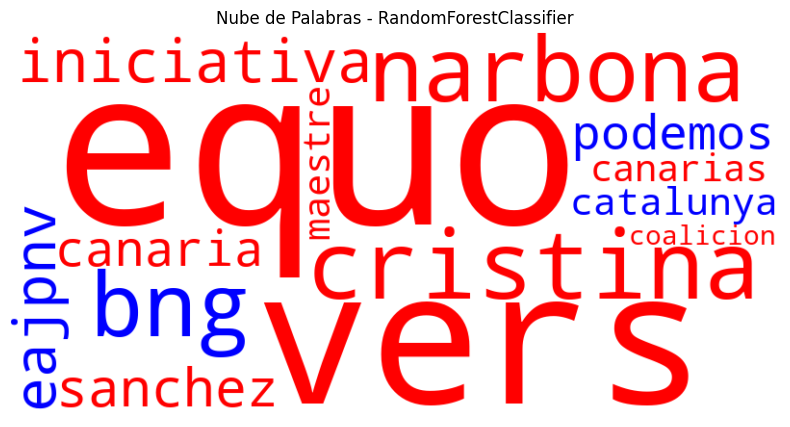

In [41]:
get_important_words_from_pipeline(marco_modelo[1])



Hay que tener presente que este modelo funcionaría más que todo para noticias de España, si se aplica con noticias de otros países es posible que tenga palabras con nombres de políticos o partidos que no reconoce, por lo cual, nuestro modelo está enfocado a nivel geógrafico y también a un periodo historico porque todas las noticias son mayoritariamente de 2018 - 2024.

## 6 Archivos de prueba

In [42]:
testData = getTestData()
nice_test_data = transfor_data(testData)

In [43]:
X_test = nice_test_data[['Titulo', 'Descripcion']]
y_pred = marco_modelo[1].predict(X_test)
y_pred_proba = marco_modelo[1].predict_proba(X_test)[:, 1]

testData['Label'] = y_pred
testData['Probabilidad'] = y_pred_proba
testData['Probabilidad'] = testData['Probabilidad'].apply(lambda x: round(x, 4))

testData.to_csv(f'particion_prueba_estudiantes.csv', sep=';', index=False)

En el archivo del repo particion_prueba_estudiantes.csv están los resultados

In [62]:
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from num2words import num2words
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode(
              'ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words


def normalize_text(text, repetar_español=False):
    if not repetar_español:
        text = text.replace('á', 'a')
        text = text.replace('é', 'e')
        text = text.replace('í', 'i')
        text = text.replace('ó', 'o')
        text = text.replace('ú', 'u')
        text = text.replace('ü', 'u')
        text = text.replace('ñ', 'n')

    # Eliminate punctuation and special characters by replacing them
    text = text.replace('(', '').replace(')', '')
    text = text.replace('[', '').replace(']', '')
    text = text.replace('{', '').replace('}', '')
    text = text.replace('<', '').replace('>', '')
    return text.lower()


def to_lowercase(words, respetar_español=False):
    return [normalize_text(word, respetar_español) for word in words]


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words


def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = num2words(word, lang='es')
           new_words.append(new_word)
       else:
           new_words.append(word)
   return new_words


def remove_stopwords(words):
    nuevas_palabras = []
    for palabra in words:
        if palabra is not None:
            if palabra not in stopwords.words('spanish'):
                nuevas_palabras.append(palabra)
    return nuevas_palabras


def corregir_contracciones_espanol(texto):
    texto = texto.replace('al ', 'a el ').replace(
        'al.', 'a el.')  # "al" a "a el"
    # "del" a "de el"    # Agrega más reglas aquí según sea necesario
    texto = texto.replace('del ', 'de el ').replace('del.', 'de el.')
    return texto


def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(word) for word in words]


def lemmatize_verbs(words):
    """Simple lemmatization for verbs in list of tokenized words"""
    # Simple rule-based lemmatization (you can extend this as needed)
    lemmatized_words = []
    for word in words:
        if word.endswith('ar'):
            lemmatized_words.append(word[:-2])  # Remove 'ar' (basic rule)
        elif word.endswith('er'):
            lemmatized_words.append(word[:-2])  # Remove 'er' (basic rule)
        elif word.endswith('ir'):
            lemmatized_words.append(word[:-2])  # Remove 'ir' (basic rule)
        else:
            # Return the word as is if no rule applies
            lemmatized_words.append(word)
    return lemmatized_words


def stem_and_lemmatize(words, stems_parameter=True, lemmas_parameter=True):
    """Stem and Lemmatize words"""
    if stems_parameter and lemmas_parameter:
        stems = stem_words(words)
        lemmas = lemmatize_verbs(words)
        return stems + lemmas
    elif lemmas_parameter:
        lemmas = lemmatize_verbs(words)
        return lemmas
    elif stems_parameter:
        stems = stem_words(words)
        return stems
    else:
        return words


def preprocessing(words, respetar_español=False, respetar_ascii=False):
    words = words.split()
    words = to_lowercase(words, respetar_español)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    if not respetar_ascii:
        words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

def transfor_data_local(df):
    columnas = ['Titulo', 'Descripcion']
    df = df[columnas]
    # fill na with ''
    df = df.fillna('')
    for columna in columnas:
        df[columna] = df[columna].apply(corregir_contracciones_espanol)
        df[columna] = df[columna].apply(lambda x: preprocessing(x, False, True))
        df[columna] = df[columna].apply(lambda x: stem_and_lemmatize(x, False, True))
        df[columna] = df[columna].apply(lambda x: ' '.join(map(str, x)))
    return df
def createModel(dataframe, text_transformer):

    data_transformer = FunctionTransformer(transfor_data_local)

    X = dataframe[['Titulo', 'Descripcion']]
    y = dataframe['Label']

    # Apply TfidfVectorizer separately to 'Titulo' and 'Descripcion'
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=10
    )

    pipeline = Pipeline([
        ("data_transform", data_transformer),  # Preprocess the dataframe
        ("vectorizer", text_transformer),
        ("classifier", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results = classification_report(y_test, y_pred, output_dict=True)

    return results, pipeline

In [63]:
rawTrainData = getTrainData()

In [64]:
from sklearn.compose import ColumnTransformer

text_transformer_basic = ColumnTransformer(
    transformers=[
        ("Titulo_tfidf", TfidfVectorizer(), "Titulo"),
        ("desc_tfidf", TfidfVectorizer(), "Descripcion")
    ]
)
marco_modelo = createModel(rawTrainData, text_transformer_basic)

In [65]:
from pprint import pprint
pprint(marco_modelo[0])

{'0': {'f1-score': 0.8925715947085332,
       'precision': 0.932139061788371,
       'recall': 0.8562264677171942,
       'support': 7171.0},
 '1': {'f1-score': 0.92783203125,
       'precision': 0.9021078617546525,
       'recall': 0.9550663449939686,
       'support': 9948.0},
 'accuracy': 0.9136631812605877,
 'macro avg': {'f1-score': 0.9102018129792666,
               'precision': 0.9171234617715118,
               'recall': 0.9056464063555814,
               'support': 17119.0},
 'weighted avg': {'f1-score': 0.9130617414878143,
                  'precision': 0.9146876698884101,
                  'recall': 0.9136631812605877,
                  'support': 17119.0}}


In [66]:
import joblib

# Assuming 'pipeline' is your trained pipeline variable
joblib.dump(marco_modelo[1], 'marco_model.joblib')
print("Pipeline saved to pipeline.joblib")

Pipeline saved to pipeline.joblib


In [78]:
import json

# Randomly sample 40% of the DataFrame rows
# random_state ensures reproducibility
frac = 0.5

rawTrainData = rawTrainData.where(pd.notnull(rawTrainData), '')
sampled_data = rawTrainData.sample(frac=frac, random_state=42)

# Convert the sampled DataFrame to a list of dictionaries
data_list = sampled_data.to_dict(orient='records')

# Convert the list of dictionaries to a JSON string (ensuring non-ASCII characters are preserved)
data_json = json.dumps(data_list, ensure_ascii=False, indent=2)

# Save the JSON string to a file
with open(f'data_{str(round(frac, 2)).split('.')[1]}0%.json', 'w', encoding='utf-8') as f:
    f.write(data_json)


# Otros:
En el readme está a evaluación del trabajo en equipo